In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
import sklearn.metrics as metrics

from scipy.stats import zscore


Основная цель:

построить модель, которая будет предсказывать вероятность закрытия кредита раньше половины срока

Необходимые этапы выполнения:

Первичная предобработка данных
* Создание новых переменных + обоснование

* Анализ распределений + исключение ненужных выбросов и кривых данных

1) Формулировка целевой переменной

2) Разделение выборки на обучающую и тестовую (или кроссвалидация)

3) Обучение модели слуйчаного леса

4) Проверка качества (по метрикам из лекции)

5) Значимость переменных

6) Проверка стабильности

In [3]:
df = pd.read_csv('data.csv', sep=';')

Описание переменных:

account_rk - уникальный номер кредитного счета

utilization_dt - дата начала использования кредита

credit_type - тип кредита

duration - текущий срок жизни кредита

deb_coming - сумма поступлений на дебетовую карту

deb_transactions - сумма транзакций с дебетовой карты

insurance_payment - платежи по страховке

mob_days - кол-во дней, в которых использовалось мобильное приложение

tarif_type - тип тарифа

monthly_income_amt - доход

rp - размер регулярного платежа по кредиту

initial_term - изначальный срок по кредиту

sum_approved - одобренная сумма кредита

approv_vs_request - отношение одобренной суммы к запрошенной

loyalty_coeff - коэффициент лояльности клиента

segment - сегмент

closed_flg - флаг закрытия кредита

pd_model_new_norm- вероятность дефолта кредита

In [4]:
df

,Unnamed: 0,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
0,47242,289097.0,2018-09-23,1,21.0,40814.0,-7191.0,0.0,10.0,one,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
1,122948,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,not_one,80094.0,11486.0,32.0,225000.0,-0.663957,0.0000,4.0,0.0,0.026019
2,201566,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,one,94485.0,17008.0,38.0,280000.0,-0.675823,0.2306,4.0,0.0,0.005385
3,27012,261769.0,2018-07-11,1,28.0,-6453.0,8454.0,0.0,3.0,not_one,63285.0,8925.0,38.0,230000.0,3.689388,0.0000,4.0,0.0,0.014340
4,94025,350912.0,2019-05-28,1,5.0,11070.0,-9936.0,0.0,19.0,one,66232.0,9990.0,39.0,155000.0,-0.276433,0.0000,4.0,0.0,0.059922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209801,112723,376079.0,2019-08-13,1,16.0,-7525.0,5656.0,0.0,17.0,one,42414.0,5656.0,34.0,-30000.0,1.295852,0.0000,3.0,0.0,0.009465
209802,92871,348633.0,2019-05-22,1,20.0,29024.0,-4126.0,0.0,6.0,one,71152.0,11488.0,39.0,410000.0,2.266996,0.0000,3.0,0.0,0.054881
209803,141120,421299.0,2019-12-27,1,12.0,84928.0,12882.0,2000.0,4.0,one,72298.0,13619.0,32.0,400000.0,-0.524158,0.2633,3.0,0.0,0.064074
209804,226526,593087.0,2020-11-28,1,7.0,-2533.0,1664.0,0.0,16.0,one,58465.0,4056.0,36.0,205000.0,-0.139872,0.0904,4.0,0.0,0.049788


In [5]:
df.describe()

,Unnamed: 0,account_rk,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
count,209806.000000,209806.000000,209806.000000,209806.000000,2.098060e+05,2.098060e+05,2.098060e+05,209806.000000,2.096450e+05,209806.000000,209806.000000,2.098060e+05,209730.000000,209806.000000,200828.000000,209806.000000,2.097660e+05
mean,116540.724221,393147.629682,1.142579,13.375514,7.757978e+04,1.112506e+04,1.518593e+04,15.441265,1.066216e+05,13423.526791,39.713616,3.372021e+05,1.257751,0.104557,3.166316,0.182988,3.842215e-02
std,67294.242126,108017.403711,0.443617,9.862445,2.814664e+05,7.401360e+04,9.830093e+04,10.859992,8.229579e+04,10955.346996,20.812380,4.712353e+05,55.189840,0.154847,1.040118,0.386658,2.553234e-02
min,1.000000,169677.000000,1.000000,-5.000000,-1.500000e+04,-1.500000e+04,0.000000e+00,-5.000000,-1.611500e+04,-1767.000000,0.000000,-1.500000e+05,-1.961211,0.000000,1.000000,0.000000,3.261601e-07
25%,58274.250000,303801.250000,1.000000,6.000000,7.610000e+03,-4.926000e+03,0.000000e+00,7.000000,5.986500e+04,7002.000000,30.000000,1.200000e+05,-0.041753,0.000000,3.000000,0.000000,1.806159e-02
50%,116536.500000,381449.500000,1.000000,13.000000,2.390750e+04,4.084000e+03,0.000000e+00,14.000000,8.712400e+04,11245.000000,36.000000,2.550000e+05,1.024516,0.000000,4.000000,0.000000,3.470232e-02
75%,174881.750000,482235.500000,1.000000,20.000000,5.856375e+04,1.271400e+04,0.000000e+00,23.000000,1.264170e+05,17348.000000,42.000000,4.250000e+05,2.052155,0.199400,4.000000,0.000000,5.136182e-02
max,233117.000000,646033.000000,4.000000,46.000000,4.292220e+07,2.731533e+07,1.003166e+07,46.000000,1.048847e+06,710978.000000,189.000000,1.050500e+07,23333.864863,1.000000,4.000000,1.000000,9.999902e-02


### Типы данных в df

In [6]:
df.dtypes 

Unnamed: 0              int64
account_rk            float64
utilization_dt         object
credit_type             int64
duration              float64
deb_coming            float64
deb_transactions      float64
insurance_payment     float64
mob_days              float64
tarif_type             object
monthly_income_amt    float64
rp                    float64
initial_term          float64
sum_approved          float64
approv_vs_request     float64
loyalty_coeff         float64
segment               float64
closed_flg            float64
pd_model              float64
dtype: object

### Кодируем tarif_type

In [7]:
df.tarif_type.value_counts() 

one        153626
not_one     56180
Name: tarif_type, dtype: int64

In [8]:
tarif_type = {'not_one':0,
 'one':1}
df.tarif_type = df.tarif_type.map(tarif_type)

### Заменим все отрицательные значения на Nan

In [9]:
for cols in df.columns.tolist()[4:]:  
    df.loc[df[cols]<0, cols] = np.nan


### Ищем пропуски

In [10]:
df.isna().sum()

Unnamed: 0                0
account_rk                0
utilization_dt            0
credit_type               0
duration              15591
deb_coming            30482
deb_transactions      80688
insurance_payment         0
mob_days              11289
tarif_type                0
monthly_income_amt      256
rp                      410
initial_term              0
sum_approved          18648
approv_vs_request     54489
loyalty_coeff             0
segment                8978
closed_flg                0
pd_model                 40
dtype: int64

In [11]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Unnamed: 0 - 0.0%
account_rk - 0.0%
utilization_dt - 0.0%
credit_type - 0.0%
duration - 7.0%
deb_coming - 15.0%
deb_transactions - 38.0%
insurance_payment - 0.0%
mob_days - 5.0%
tarif_type - 0.0%
monthly_income_amt - 0.0%
rp - 0.0%
initial_term - 0.0%
sum_approved - 9.0%
approv_vs_request - 26.0%
loyalty_coeff - 0.0%
segment - 4.0%
closed_flg - 0.0%
pd_model - 0.0%


created missing indicator for: duration
created missing indicator for: deb_coming
created missing indicator for: deb_transactions
created missing indicator for: mob_days
created missing indicator for: monthly_income_amt
created missing indicator for: rp
created missing indicator for: sum_approved
created missing indicator for: approv_vs_request
created missing indicator for: segment
created missing indicator for: pd_model


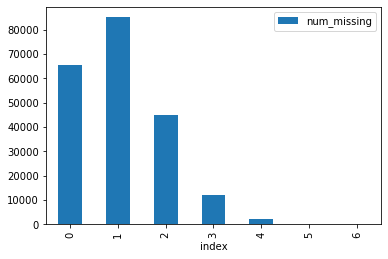

In [12]:
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# затем на основе индикатора строим гистограмму
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')


In [13]:
# отбрасываем столбцы с большим количеством пропусков
cols_to_drop = ['deb_transactions']
df_less_missing = df.drop(cols_to_drop, axis=1)

In [14]:
# отбрасываем строки с большим количеством пропусков
ind_missing = df_less_missing[df_less_missing['num_missing'] > 4].index
df_less_missing = df_less_missing.drop(ind_missing, axis=0)

In [15]:
df_less_missing = df_less_missing.drop(['Unnamed: 0', 'account_rk', 'utilization_dt','duration_ismissing', 'deb_coming_ismissing',
       'deb_transactions_ismissing', 'mob_days_ismissing',
       'monthly_income_amt_ismissing', 'rp_ismissing',
       'sum_approved_ismissing', 'approv_vs_request_ismissing',
       'segment_ismissing', 'pd_model_ismissing', 'num_missing'],axis = 1)

In [16]:
df_less_missing

,credit_type,duration,deb_coming,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
0,1,21.0,40814.0,0.0,10.0,1.0,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
1,1,12.0,76528.0,0.0,23.0,0.0,80094.0,11486.0,32.0,225000.0,NaN,0.0000,4.0,0.0,0.026019
2,1,1.0,49854.0,0.0,31.0,1.0,94485.0,17008.0,38.0,280000.0,NaN,0.2306,4.0,0.0,0.005385
3,1,28.0,NaN,0.0,3.0,0.0,63285.0,8925.0,38.0,230000.0,3.689388,0.0000,4.0,0.0,0.014340
4,1,5.0,11070.0,0.0,19.0,1.0,66232.0,9990.0,39.0,155000.0,NaN,0.0000,4.0,0.0,0.059922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209801,1,16.0,NaN,0.0,17.0,1.0,42414.0,5656.0,34.0,NaN,1.295852,0.0000,3.0,0.0,0.009465
209802,1,20.0,29024.0,0.0,6.0,1.0,71152.0,11488.0,39.0,410000.0,2.266996,0.0000,3.0,0.0,0.054881
209803,1,12.0,84928.0,2000.0,4.0,1.0,72298.0,13619.0,32.0,400000.0,NaN,0.2633,3.0,0.0,0.064074
209804,1,7.0,NaN,0.0,16.0,1.0,58465.0,4056.0,36.0,205000.0,NaN,0.0904,4.0,0.0,0.049788


# Работа с выбросами

In [17]:
df_less_missing.columns


Index(['credit_type', 'duration', 'deb_coming', 'insurance_payment',
       'mob_days', 'tarif_type', 'monthly_income_amt', 'rp', 'initial_term',
       'sum_approved', 'approv_vs_request', 'loyalty_coeff', 'segment',
       'closed_flg', 'pd_model'],
      dtype='object')

f:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
f:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


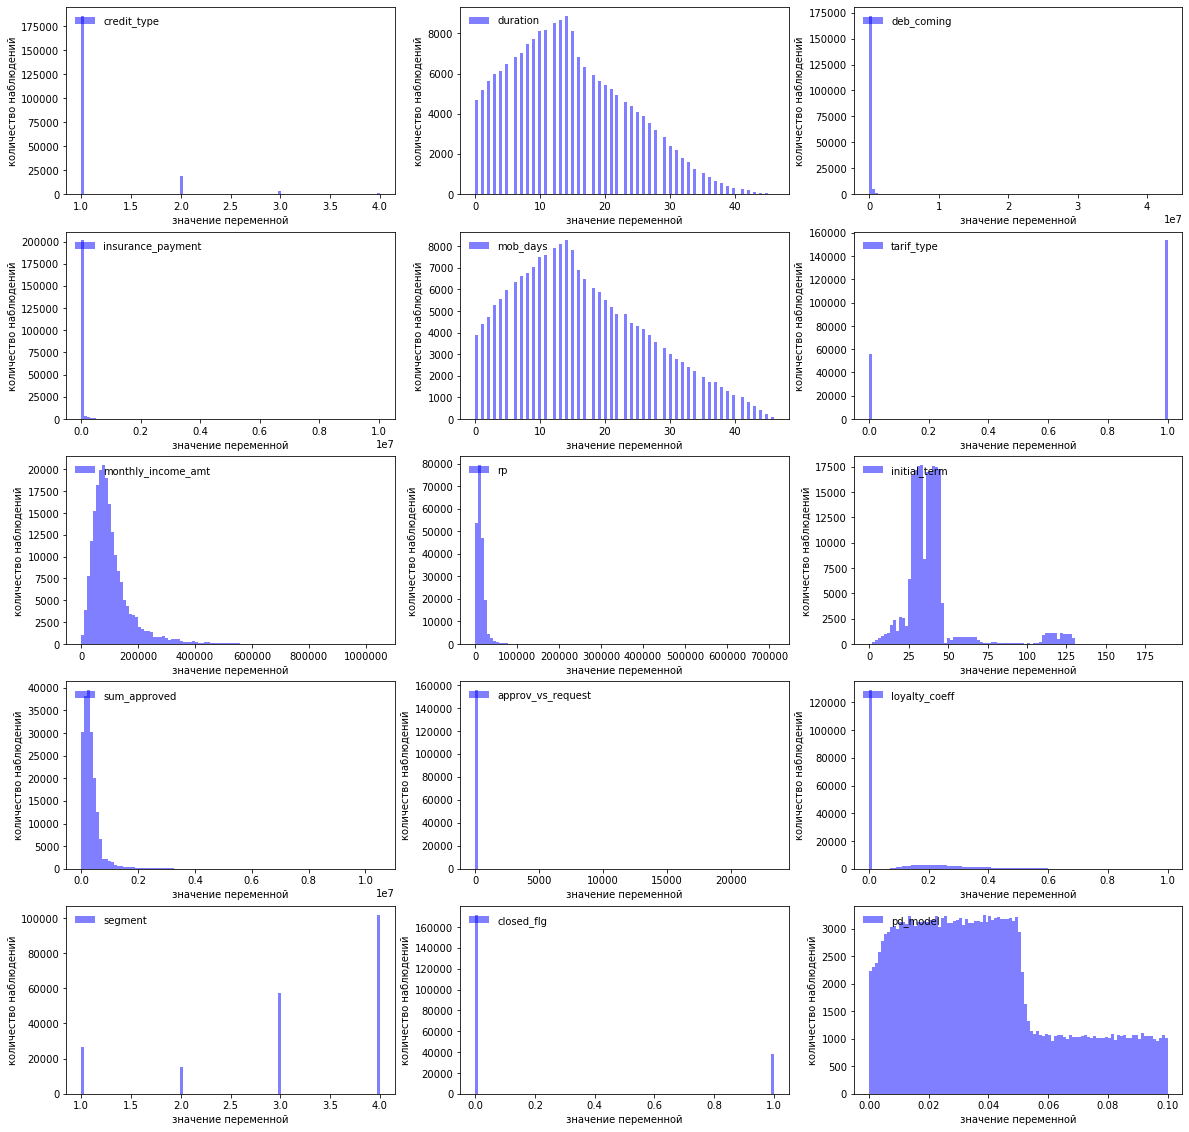

In [18]:

a = np.array(df_less_missing[['credit_type', 'duration','deb_coming', 'insurance_payment', 
           'mob_days', 'tarif_type','monthly_income_amt', 'rp', 
           'initial_term', 'sum_approved','approv_vs_request', 
           'loyalty_coeff', 'segment', 'closed_flg','pd_model']])

ncols = 3
nrows = int(np.ceil(len(a[:][0]) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        if counter < len(a[:][0]):
            ax.hist(a[:,counter], bins= 100, color='blue', alpha=0.5, label='{}'.format(df_less_missing[['credit_type', 'duration','deb_coming', 'insurance_payment', 
           'mob_days', 'tarif_type','monthly_income_amt', 'rp', 
           'initial_term', 'sum_approved','approv_vs_request', 
           'loyalty_coeff', 'segment', 'closed_flg','pd_model']].columns[counter]))
            ax.set_xlabel('значение переменной')
            ax.set_ylabel('количество наблюдений')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)
        else:
            ax.set_axis_off()
        counter += 1

plt.show()

Из гистограмм видно, что в данных имеются выбросы. Воспользуемся z-score, для борьбы с ними.  Принято считать, что наблюдение выходит за пределы нормального, если абсолютное значение его z-оценки превышает 2.

In [19]:
df_less_missing

,credit_type,duration,deb_coming,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
0,1,21.0,40814.0,0.0,10.0,1.0,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
1,1,12.0,76528.0,0.0,23.0,0.0,80094.0,11486.0,32.0,225000.0,NaN,0.0000,4.0,0.0,0.026019
2,1,1.0,49854.0,0.0,31.0,1.0,94485.0,17008.0,38.0,280000.0,NaN,0.2306,4.0,0.0,0.005385
3,1,28.0,NaN,0.0,3.0,0.0,63285.0,8925.0,38.0,230000.0,3.689388,0.0000,4.0,0.0,0.014340
4,1,5.0,11070.0,0.0,19.0,1.0,66232.0,9990.0,39.0,155000.0,NaN,0.0000,4.0,0.0,0.059922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209801,1,16.0,NaN,0.0,17.0,1.0,42414.0,5656.0,34.0,NaN,1.295852,0.0000,3.0,0.0,0.009465
209802,1,20.0,29024.0,0.0,6.0,1.0,71152.0,11488.0,39.0,410000.0,2.266996,0.0000,3.0,0.0,0.054881
209803,1,12.0,84928.0,2000.0,4.0,1.0,72298.0,13619.0,32.0,400000.0,NaN,0.2633,3.0,0.0,0.064074
209804,1,7.0,NaN,0.0,16.0,1.0,58465.0,4056.0,36.0,205000.0,NaN,0.0904,4.0,0.0,0.049788


In [25]:
df_clear = df_less_missing[(np.abs(stats.zscore(df_less_missing,nan_policy='omit')) < 3).all(axis=1)]

f:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


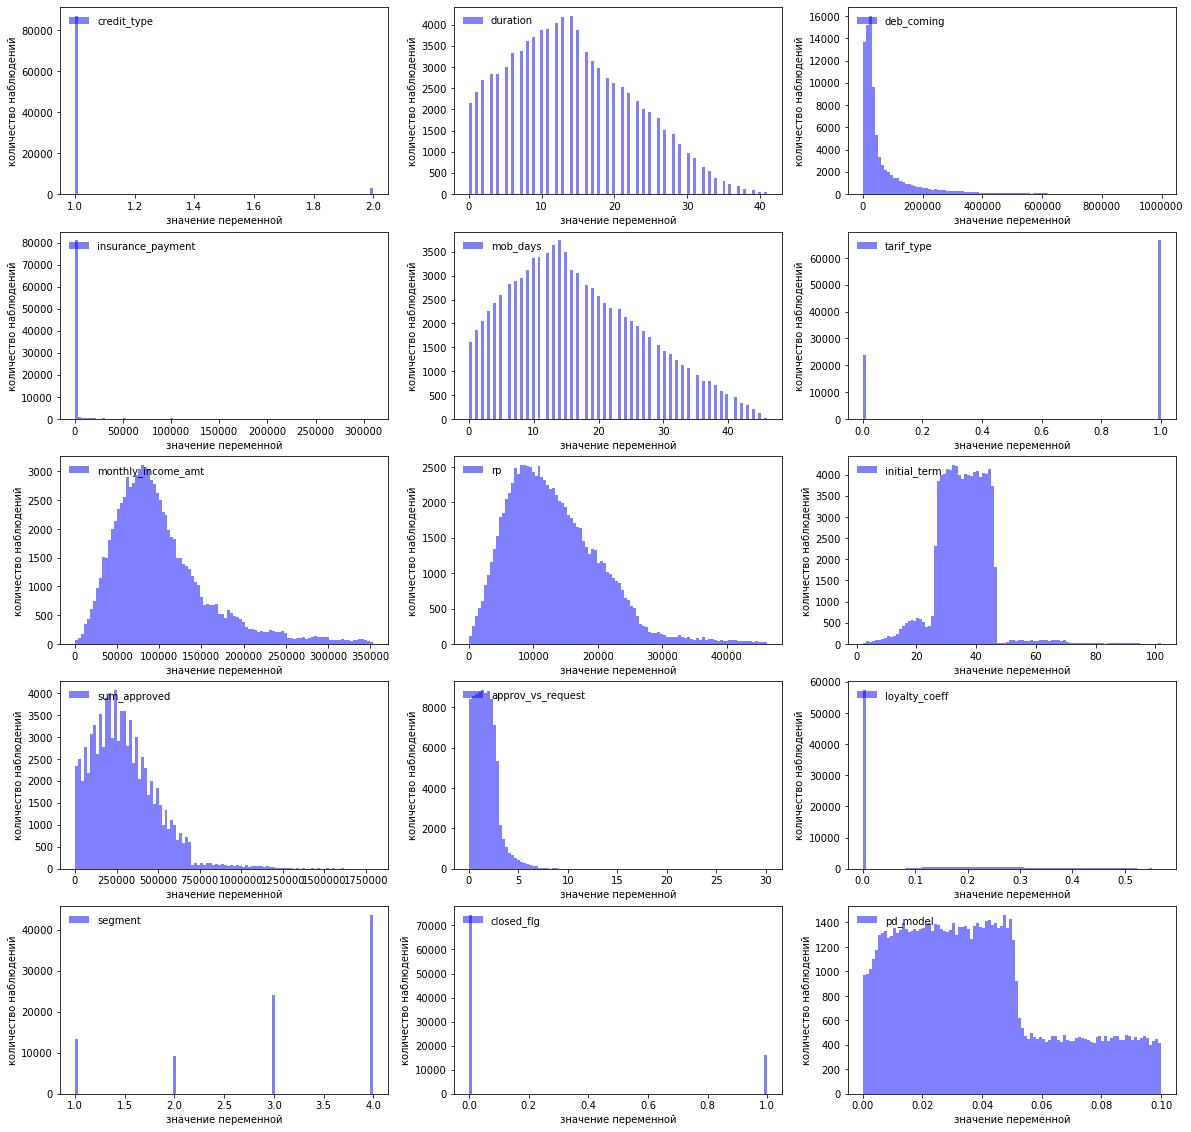

In [26]:

a = np.array(df_clear[['credit_type', 'duration','deb_coming', 'insurance_payment', 
           'mob_days', 'tarif_type','monthly_income_amt', 'rp', 
           'initial_term', 'sum_approved','approv_vs_request', 
           'loyalty_coeff', 'segment', 'closed_flg','pd_model']])

ncols = 3
nrows = int(np.ceil(len(a[:][0]) / (1.0*ncols)))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))

counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        if counter < len(a[:][0]):
            ax.hist(a[:,counter], bins= 100, color='blue', alpha=0.5, label='{}'.format(df_clear[['credit_type', 'duration','deb_coming', 'insurance_payment', 
           'mob_days', 'tarif_type','monthly_income_amt', 'rp', 
           'initial_term', 'sum_approved','approv_vs_request', 
           'loyalty_coeff', 'segment', 'closed_flg','pd_model']].columns[counter]))
            ax.set_xlabel('значение переменной')
            ax.set_ylabel('количество наблюдений')
            leg = ax.legend(loc='upper left')
            leg.draw_frame(False)
        else:
            ax.set_axis_off()
        counter += 1

plt.show()

### Создадим целевую переменную 

In [27]:
Y = ((df_clear.duration / df_clear.initial_term > 0.5) & (df_clear.closed_flg == 1)).astype(int)
Y 

0         0
12        0
13        0
15        0
20        0
         ..
209797    0
209799    0
209800    0
209802    0
209805    0
Length: 90280, dtype: int32

In [28]:
df_clear

,credit_type,duration,deb_coming,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
0,1,21.0,40814.0,0.0,10.0,1.0,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
12,1,6.0,24317.0,0.0,15.0,1.0,81983.0,16592.0,23.0,395000.0,1.384584,0.2300,3.0,0.0,0.010184
13,1,0.0,40190.0,0.0,13.0,1.0,91575.0,15948.0,36.0,185000.0,2.264389,0.1642,4.0,0.0,0.073504
15,1,14.0,136082.0,0.0,38.0,1.0,146587.0,4466.0,38.0,490000.0,1.224799,0.0000,4.0,0.0,0.038697
20,1,4.0,24945.0,0.0,28.0,1.0,135130.0,8476.0,34.0,345000.0,0.707651,0.0000,4.0,0.0,0.015901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209797,1,12.0,23964.0,0.0,12.0,1.0,65176.0,9014.0,34.0,105000.0,2.905617,0.2582,4.0,1.0,0.014361
209799,1,15.0,56596.0,0.0,32.0,1.0,145059.0,20541.0,34.0,335000.0,2.950345,0.0000,1.0,0.0,0.026298
209800,1,8.0,15060.0,0.0,16.0,0.0,124682.0,12962.0,27.0,245000.0,3.381394,0.0000,2.0,0.0,0.003915
209802,1,20.0,29024.0,0.0,6.0,1.0,71152.0,11488.0,39.0,410000.0,2.266996,0.0000,3.0,0.0,0.054881


# Разделим на треин и тест

In [120]:
# x - вектор значений признаков, y - вектор со значениями целевой переменной
X_train, X_test, y_train, y_test = train_test_split(df_clear, Y , test_size=0.3, random_state=4)

In [147]:
tree_params = {'max_depth': range(1,20),
               'max_features': range(1,19),
               'criterion': ('gini', 'entropy')
              }

tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params,
                         cv=5, n_jobs=-1,verbose=True)

tree_grid.fit(X_train, y_train)
tree_grid.best_params_
tree_grid.best_score_
y_pr_best = tree_grid.predict(X_test)
clf = tree_grid.best_estimator_
print(clf)

Fitting 5 folds for each of 684 candidates, totalling 3420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1464 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 2364 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3405 out of 3420 | elapsed:  1.3min remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 3420 out of 3420 | elapsed:  1.3min finished


DecisionTreeClassifier(criterion='entropy', max_depth=16, max_features=15)


# Обучим модели

In [203]:
classifier_RandomForest = RandomForestClassifier(n_estimators=100,max_depth=7,criterion='entropy')
classifier_RandomForest.fit(X_train, y_train)
y_pred_RandomForest = classifier_RandomForest.predict(X_test)

In [213]:
classifier_DecisionTree = DecisionTreeClassifier(max_depth=3,criterion='entropy')
classifier_DecisionTree.fit(X_train, y_train)
y_pred_DecisionTree = classifier_DecisionTree.predict(X_test)

# Оценим качество

### Случайный лес

In [214]:
print('Матрица ошибок: \n', confusion_matrix(y_test,y_pred_RandomForest),'\n')
print('Метрики: \n', classification_report(y_test,y_pred_RandomForest),'\n')
print('Accuracy: \n',accuracy_score(y_test, y_pred_RandomForest))


Матрица ошибок: 
 [[25302    27]
 [  340  1415]] 

Метрики: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     25329
           1       0.98      0.81      0.89      1755

    accuracy                           0.99     27084
   macro avg       0.98      0.90      0.94     27084
weighted avg       0.99      0.99      0.99     27084
 

Accuracy: 
 0.9864495643184168


### Дерево решений

In [215]:
print('Матрица ошибок: \n', confusion_matrix(y_test,y_pred_DecisionTree),'\n')
print('Метрики: \n', classification_report(y_test,y_pred_DecisionTree),'\n')
print('Accuracy: \n',accuracy_score(y_test, y_pred_DecisionTree))


Матрица ошибок: 
 [[25104   225]
 [  362  1393]] 

Метрики: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     25329
           1       0.86      0.79      0.83      1755

    accuracy                           0.98     27084
   macro avg       0.92      0.89      0.91     27084
weighted avg       0.98      0.98      0.98     27084
 

Accuracy: 
 0.9783266873430808


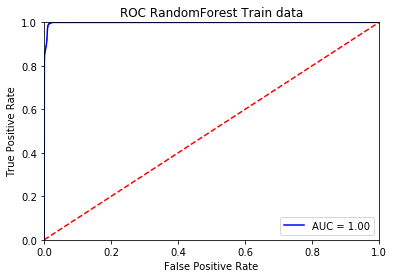

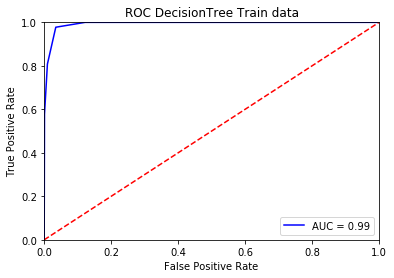

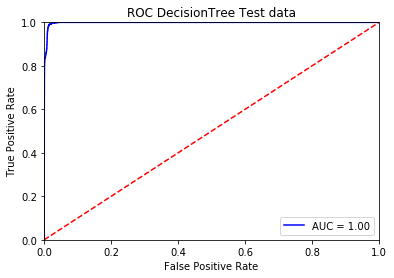

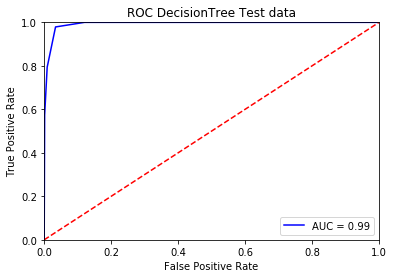

In [216]:
# TRAIN RandomForest
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier_RandomForest.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC RandomForest Train data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# TRAIN DecisionTree
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier_DecisionTree.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_train, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC DecisionTree Train data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# TEST RandomForest
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier_RandomForest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC DecisionTree Test data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# TEST DecisionTree
# calculate the fpr and tpr for all thresholds of the classification
probs = classifier_DecisionTree.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
# method I: plt
import matplotlib.pyplot as plt
plt.title('ROC DecisionTree Test data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



auc=0.982


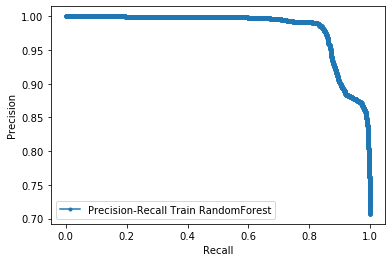

auc=0.921


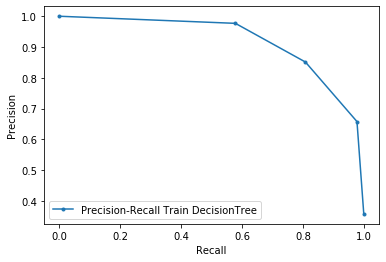

auc=0.976


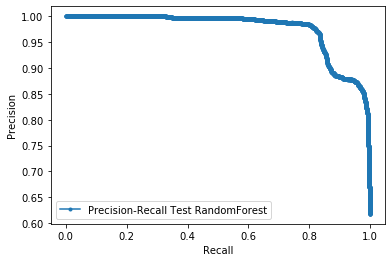

auc=0.918


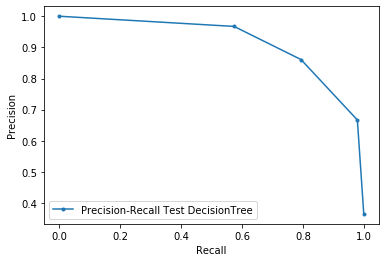

In [217]:
#TRAIN
probs = classifier_RandomForest.predict_proba(X_train)
preds = probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_train, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall Train RandomForest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#TRAIN
probs = classifier_DecisionTree.predict_proba(X_train)
preds = probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_train, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall Train DecisionTree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#TEST
probs = classifier_RandomForest.predict_proba(X_test)
preds = probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall Test RandomForest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

#TEST
probs = classifier_DecisionTree.predict_proba(X_test)
preds = probs[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, preds)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
pyplot.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall Test DecisionTree')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [218]:
c = classifier_DecisionTree.feature_importances_
for i,v in enumerate(c):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.30590
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.05640
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.63769
Feature: 14, Score: 0.00000


In [219]:
df_clear.columns

Index(['credit_type', 'duration', 'deb_coming', 'insurance_payment',
       'mob_days', 'tarif_type', 'monthly_income_amt', 'rp', 'initial_term',
       'sum_approved', 'approv_vs_request', 'loyalty_coeff', 'segment',
       'closed_flg', 'pd_model'],
      dtype='object')